In [1]:
import numpy as np
import pickle
from pathlib import Path
import src.reader as Reader
import yaml
import sys
import argparse
import matplotlib.pyplot as plt

In [2]:
# Initialize temporary containers
DataList = []
Setup = {}
RawData = {}
RawPrediction = {}
RawPredictionError = {}
RawDesign = {}

In [3]:
ConfigFile = "yaml/Exponential20221012RBF.yaml"

with open(ConfigFile, "r") as stream:
    try:
        Setup = yaml.safe_load(stream)

    except yaml.YAMLError as exc:
        print(exc)
        exit()

Tag = Setup["Tag"]

DataList = list(Setup['Data'].keys())
for Item in DataList:
    RawData[Item] = Reader.ReadData(Setup['BaseDirectory'] + Setup['Data'][Item]['Data'])
    RawPrediction[Item] = Reader.ReadPrediction(Setup['BaseDirectory'] + Setup['Data'][Item]['Prediction'])
    RawPredictionError[Item] = Reader.ReadPrediction(Setup['BaseDirectory'] + Setup['Data'][Item]['PredictionError'])

RawDesign = Reader.ReadDesign(Setup['BaseDirectory'] + Setup['Design']['File'])
for I in Setup['Design']['LogScale']:
    RawDesign['Design'][:, I] = np.log(RawDesign['Design'][:, I])
    RawDesign['Parameter'][I] = 'log(' + RawDesign['Parameter'][I] + ')'

    Setup['Design']['Range'][I][0] = np.log(Setup['Design']['Range'][I][0])
    Setup['Design']['Range'][I][1] = np.log(Setup['Design']['Range'][I][1])

In [4]:
def InsertZeroDesign(Raw, Locations):
    for Location in Locations:
        Raw = np.insert(Raw, Location, np.zeros(Raw.shape[1]), axis = 0)
    return Raw

def DeleteRawData(Raw, Items):
    Raw["Data"]["x"]    = np.delete(Raw["Data"]["x"], Items, axis = 0)
    if 'xerr' in Raw['Data']:
        Raw["Data"]["xerr"] = np.delete(Raw["Data"]["xerr"], Items, axis = 0)
    Raw["Data"]["y"]    = np.delete(Raw["Data"]["y"], Items, axis = 0)
    for item in Raw["Data"]["yerr"]:
        Raw["Data"]["yerr"][item] = np.delete(Raw["Data"]["yerr"][item], Items, axis = 0)

In [5]:
# Clean up points
for Item in DataList:
    if 'DataExclude' in Setup['Data'][Item]:
        DeleteRawData(RawData[Item], Setup['Data'][Item]['DataExclude'])
    if 'PredictionExclude' in Setup['Data'][Item]:
        RawPrediction[Item]["Prediction"] = np.delete(RawPrediction[Item]["Prediction"], Setup['Data'][Item]['PredictionExclude'], axis = 1)
        RawPredictionError[Item]["Prediction"] = np.delete(RawPredictionError[Item]["Prediction"], Setup['Data'][Item]['PredictionExclude'], axis = 1)

# Clean up low energy points
if 'DataCut' in Setup and 'MinPT' in Setup['DataCut']:
    for Item in DataList:
        DeleteCount = sum(i < Setup['DataCut']['MinPT'] for i in RawData[Item]["Data"]["x"])
        DeleteRawData(RawData[Item], range(0, DeleteCount))
        RawPrediction[Item]['Prediction'] = np.delete(RawPrediction[Item]["Prediction"], range(0, DeleteCount), axis = 1)
        RawPredictionError[Item]['Prediction'] = np.delete(RawPredictionError[Item]["Prediction"], range(0, DeleteCount), axis = 1)
                                                                                                                       
# Delete prediction that are longer than available design points
NDesign = RawDesign['Design'].shape[0]
for Item in DataList:
    if RawPrediction[Item]['Prediction'].shape[0] > NDesign:
        ToDelete = RawPrediction[Item]['Prediction'].shape[0] - NDesign
        RawPrediction[Item]['Prediction'] = np.delete(RawPrediction[Item]['Prediction'], range(NDesign, RawPrediction[Item]['Prediction'].shape[0]), axis = 0)
    if RawPredictionError[Item]['Prediction'].shape[0] > NDesign:
        ToDelete = RawPredictionError[Item]['Prediction'].shape[0] - NDesign
        RawPredictionError[Item]['Prediction'] = np.delete(RawPredictionError[Item]['Prediction'], range(NDesign, RawPredictionError[Item]['Prediction'].shape[0]), axis = 0)

# Remove bad design points
InputDesignCount = RawDesign['Design'].shape[0]
ListToDelete = [x for x in Setup['Design']['ListToDelete'] if x < InputDesignCount]
DesignIndex = np.delete(range(0, InputDesignCount), ListToDelete)

In [6]:
SurvivedAllCount = []
SurvivedCentralCount = []
SurvivedPeripheralCount = []
for Limit in np.arange(1.0, 3.0, 0.05):
    SurvivedAll = len(DesignIndex)
    SurvivedCentral = len(DesignIndex)
    SurvivedPeripheral = len(DesignIndex)
    for I in DesignIndex:
        if sum(any(RawPrediction[Item]['Prediction'][I,:] > Limit) for Item in DataList) > 0:
            SurvivedAll = SurvivedAll - 1
        if sum(any(RawPrediction[Item]['Prediction'][I,:] > Limit) for Item in DataList if Setup['Data'][Item]['Attribute']['CentralityMax'] <= 10) > 0:
            SurvivedCentral = SurvivedCentral - 1
        if sum(any(RawPrediction[Item]['Prediction'][I,:] > Limit) for Item in DataList if Setup['Data'][Item]['Attribute']['CentralityMax'] > 10) > 0:
            SurvivedPeripheral = SurvivedPeripheral - 1
    SurvivedAllCount.append(SurvivedAll)
    SurvivedCentralCount.append(SurvivedCentral)
    SurvivedPeripheralCount.append(SurvivedPeripheral)


    

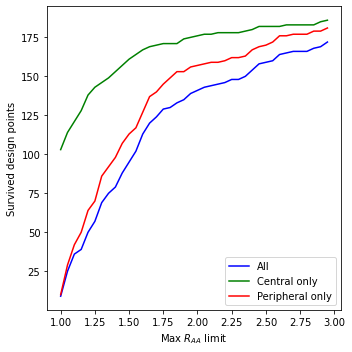

In [9]:
figure, axes = plt.subplots(figsize = (5, 5))
axes.plot(np.arange(1.0, 3.0, 0.05), SurvivedAllCount, 'b-', label = 'All')
axes.plot(np.arange(1.0, 3.0, 0.05), SurvivedCentralCount, 'g-', label = 'Central only')
axes.plot(np.arange(1.0, 3.0, 0.05), SurvivedPeripheralCount, 'r-', label = 'Peripheral only')

axes.set_xlabel(r'Max $R_{AA}$ limit')
axes.set_ylabel('Survived design points')
axes.legend(loc = 'lower right')

plt.tight_layout()

tag = Setup['Tag']
figure.savefig(f'result/{tag}/plots/DesignPointSurvival.pdf', dpi = 192)


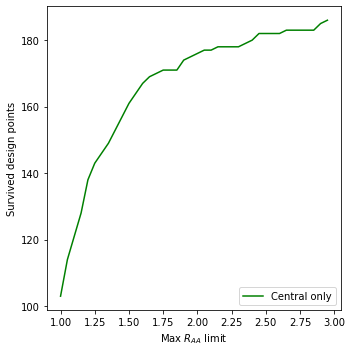

In [10]:
figure, axes = plt.subplots(figsize = (5, 5))
axes.plot(np.arange(1.0, 3.0, 0.05), SurvivedCentralCount, 'g-', label = 'Central only')

axes.set_xlabel(r'Max $R_{AA}$ limit')
axes.set_ylabel('Survived design points')
axes.legend(loc = 'lower right')

plt.tight_layout()

tag = Setup['Tag']
figure.savefig(f'result/{tag}/plots/DesignPointSurvivalCentral.pdf', dpi = 192)
